## Text Mining em documentos de Defesa Norte Americanos

##### Objetivo:
* Ver a quantidade de vezes que palavras relacionadas com cyber security aparecem aparecem conforme passam os anos.

##### Procedimento:
1. Ler cada documento deixando claro a que ano se refere
2. Remover pontuações e stopwords (lembrando de adicionar palavras como us, united, states)
3. Realizar a contagem de palavras
4. Plotar a evolução histórica dessa contagem

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from PyPDF2 import PdfFileReader
from bs4 import BeautifulSoup
import re
import string
import glob
import os
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from collections import Counter


%matplotlib inline

Criando função que lerá documentos

#### Em primeiro momento, será feita uma análise geral levando em conta todos os documentos de uma só vez. Após isso, será analisado cada documento separadamente

In [2]:
def ler_(arquivo): #Essa versão é a que está valendo
    pdf = open(arquivo, "rb")
    reader = PdfFileReader(pdf)
    tamanho = reader.numPages
    
    pages = []
    
    for i in range(tamanho):
        pages.append(reader.getPage(i).extractText())
        
    text = " ".join(pages)
    
    return text

In [3]:
textos = os.listdir('textos')

In [4]:
textos[0][:4]

'2006'

Lendo documentos e armazenando por ano num DataFrame

In [5]:
def ler_todos_arquivos(local = 'textos'):
    
    textos = os.listdir(local)
    ano = []
    text = []
    
    for texto in textos:
        ano.append(texto[:4])
        text.append(ler_('textos/'+texto))
    
    df = pd.DataFrame(text, columns=['text'], index=ano)
    print(df.head())
    
    return df

In [6]:
asd = ler_todos_arquivos()

                                                   text
2006        Annual Threat Assessment of the Director...
2007    \n Annual Threat Assessment \nof the \nDirec...
2008       Annual Threat Assessment of the   Intelli...
2009       Annual Threat Assessment of the   Intelli...
2010      Annual Threat Assessment of the   US Intel...


In [7]:
ano = []
text = []
for texto in textos:
    ano.append(texto[:4])
    text.append(ler_('textos/'+texto))

In [8]:
df = pd.DataFrame(text, columns=['text'], index=ano)

In [9]:
df.head()

,text
2006,Annual Threat Assessment of the Director...
2007,\n Annual Threat Assessment \nof the \nDirec...
2008,Annual Threat Assessment of the Intelli...
2009,Annual Threat Assessment of the Intelli...
2010,Annual Threat Assessment of the US Intel...


A arquivo do ano de 2011 é um pdf scaneado!

In [10]:
nltk.download('stopwords')
stop = stopwords.words('english')
#punctuation = list(string.punctuation)
#stop.update(punctuation)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\galag\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
#Adicionando algumas palavras que se percebeu ser comum nos arquivos e que não somam muito no objetivo
stop.append('us')
stop.append('united')
stop.append('states')
stop.append('also')

#### Tirando caracteres especiais

In [12]:
alphanumeric = lambda x: re.sub(r"""\w*\d\w*""", ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
remove_br = lambda x: re.sub(r""" br """, ' ', x.lower())
remove_n = lambda x: re.sub(r""" [\r\n]+ """, ' ', x.lower())
line = lambda x: x.strip()
linen =  lambda x: re.sub("\n","",x)


df['text_b'] = df.text.map(alphanumeric).map(punc_lower).map(remove_br).map(remove_n).map(line).map(linen)
df['text_b'] = df['text_b'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))



In [13]:
df.head()

,text,text_b
2006,Annual Threat Assessment of the Director...,annual threat assessment of the director of na...
2007,\n Annual Threat Assessment \nof the \nDirec...,annual threat assessment of the director of na...
2008,Annual Threat Assessment of the Intelli...,annual threat assessment of the intelligence...
2009,Annual Threat Assessment of the Intelli...,annual threat assessment of the intelligence...
2010,Annual Threat Assessment of the US Intel...,annual threat assessment of the us intellige...


Criando função que vai contabilizar as palavras no conjunto de arquivos

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_text_ngrams(corpus, g):
    vec = CountVectorizer(ngram_range=(g, g), stop_words=stop).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

In [15]:
most_common_uni = get_top_text_ngrams(df.text_b,1)
most_common_uni = dict(most_common_uni)

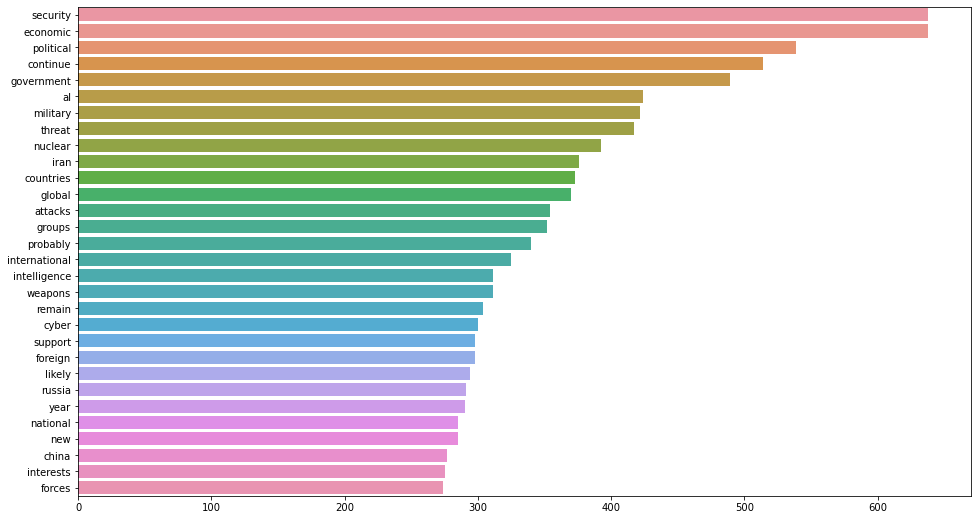

In [14]:
plt.figure(figsize = (16,9))
sns.barplot(x=list(most_common_uni.values())[:30],y=list(most_common_uni.keys())[:30])
plt.savefig('barra1.png')
plt.show()

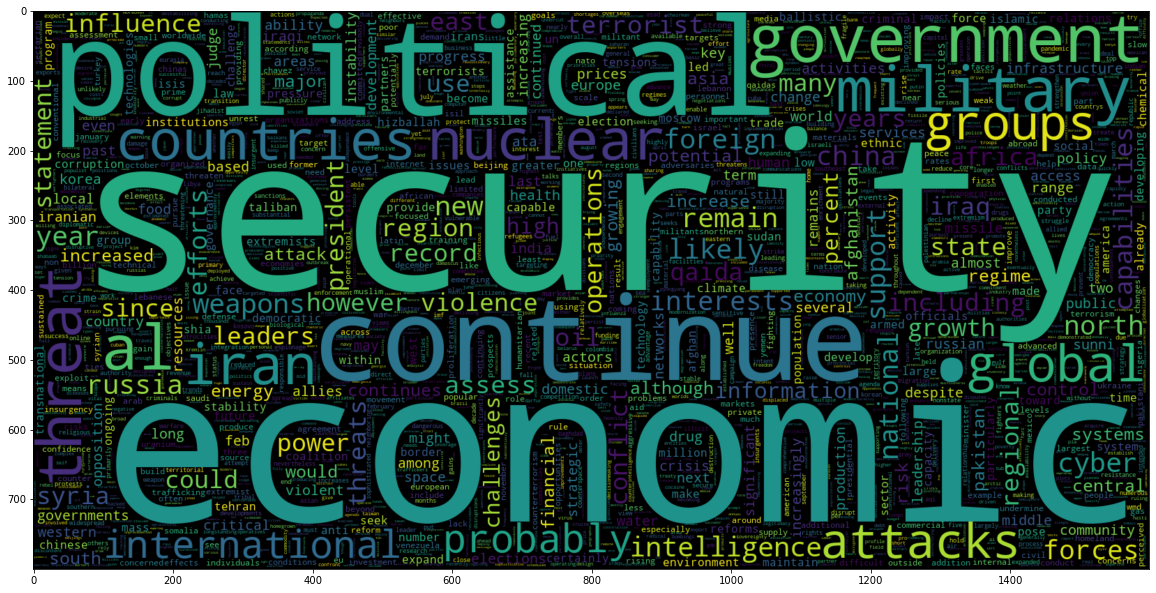

In [19]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop).fit_words(most_common_uni)
plt.imshow(wc , interpolation = 'bilinear')
#plt.savefig('worldAll1')
plt.show()

In [16]:
tudo = pd.DataFrame(data = most_common_uni.values(), index = most_common_uni.keys(), columns = ['quantidade'])

#### Quantidade total de palavras

In [17]:
tudo.quantidade.sum()

104434

In [18]:
tudo.quantidade 

security              638
economic              638
political             539
continue              514
government            489
                     ... 
ivan                    1
fraying                 1
miguel                  1
institutionalizing      1
canel                   1
Name: quantidade, Length: 10581, dtype: int64

In [19]:
(tudo.quantidade / tudo.quantidade.sum())*100

security              0.610912
economic              0.610912
political             0.516115
continue              0.492177
government            0.468238
                        ...   
ivan                  0.000958
fraying               0.000958
miguel                0.000958
institutionalizing    0.000958
canel                 0.000958
Name: quantidade, Length: 10581, dtype: float64

In [20]:
most_common_bi = get_top_text_ngrams(df.text_b,2)
most_common_bi = dict(most_common_bi)

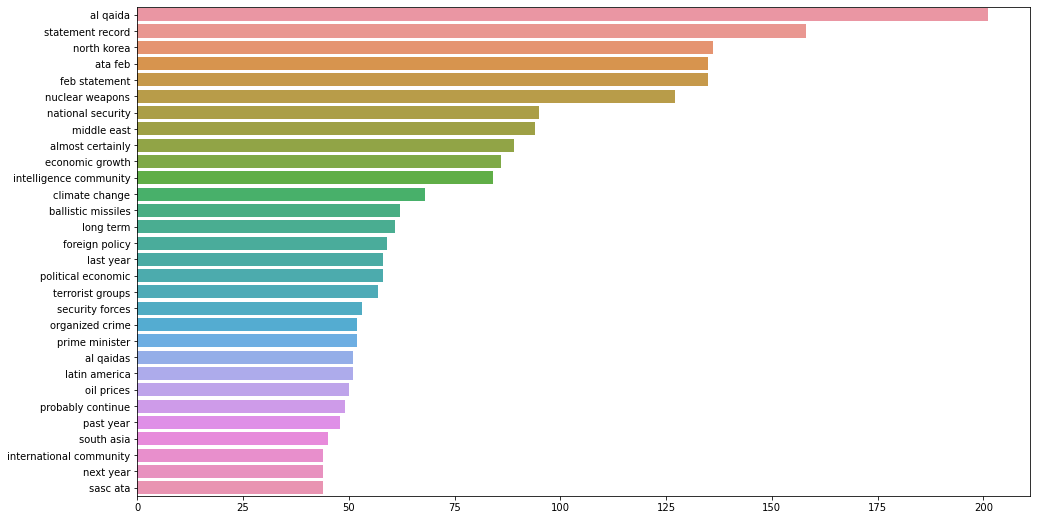

In [21]:
plt.figure(figsize = (16,9))
sns.barplot(x=list(most_common_bi.values())[:30],y=list(most_common_bi.keys())[:30])
plt.savefig('barra2.png')
plt.show()

In [19]:
#most_common_bi

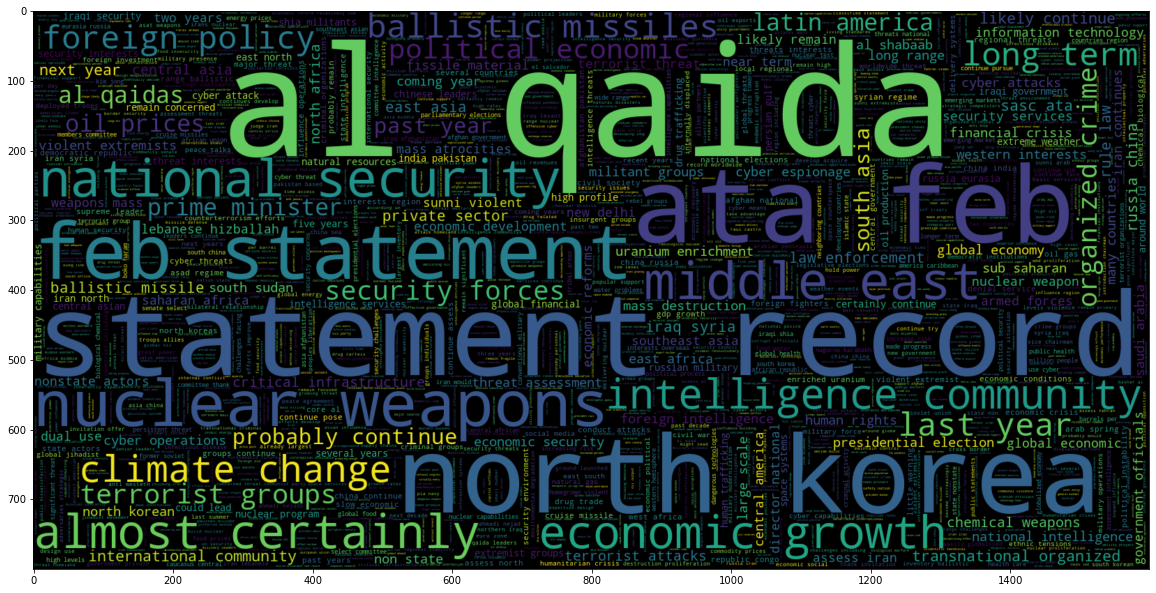

In [20]:
plt.figure(figsize = (20,20)) # Text that is not Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).fit_words(most_common_bi)
plt.imshow(wc , interpolation = 'bilinear')
plt.savefig('worldAll2')
plt.show()

In [21]:
#Para fazer tokenização

df['token'] = df.text_b.map(word_tokenize)

In [22]:
df.head()

,text,text_b,token
2006,Annual Threat Assessment of the Director...,annual threat assessment of the director of na...,"[annual, threat, assessment, of, the, director..."
2007,\n Annual Threat Assessment \nof the \nDirec...,annual threat assessment of the director of na...,"[annual, threat, assessment, of, the, director..."
2008,Annual Threat Assessment of the Intelli...,annual threat assessment of the intelligence...,"[annual, threat, assessment, of, the, intellig..."
2009,Annual Threat Assessment of the Intelli...,annual threat assessment of the intelligence...,"[annual, threat, assessment, of, the, intellig..."
2010,Annual Threat Assessment of the US Intel...,annual threat assessment of the us intellige...,"[annual, threat, assessment, of, the, us, inte..."


In [23]:
stop_lambda = lambda x: [y for y in x if y not in stop]
#aplica a função na coluna dos tokens
df['tokens_stop'] = df.token.apply(stop_lambda)
df.head()

,text,text_b,token,tokens_stop
2006,Annual Threat Assessment of the Director...,annual threat assessment of the director of na...,"[annual, threat, assessment, of, the, director...","[annual, threat, assessment, director, nationa..."
2007,\n Annual Threat Assessment \nof the \nDirec...,annual threat assessment of the director of na...,"[annual, threat, assessment, of, the, director...","[annual, threat, assessment, director, nationa..."
2008,Annual Threat Assessment of the Intelli...,annual threat assessment of the intelligence...,"[annual, threat, assessment, of, the, intellig...","[annual, threat, assessment, intelligence, com..."
2009,Annual Threat Assessment of the Intelli...,annual threat assessment of the intelligence...,"[annual, threat, assessment, of, the, intellig...","[annual, threat, assessment, intelligence, com..."
2010,Annual Threat Assessment of the US Intel...,annual threat assessment of the us intellige...,"[annual, threat, assessment, of, the, us, inte...","[annual, threat, assessment, intelligence, com..."


In [24]:
# partes de speech tagging
from nltk.tag import pos_tag
nltk.download('averaged_perceptron_tagger')
pos_lambda = lambda x: nltk.pos_tag(x)
df['tokens_pos'] = (df.tokens_stop.apply(pos_lambda))
df.head()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\galag\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,text,text_b,token,tokens_stop,tokens_pos
2006,Annual Threat Assessment of the Director...,annual threat assessment of the director of na...,"[annual, threat, assessment, of, the, director...","[annual, threat, assessment, director, nationa...","[(annual, JJ), (threat, NN), (assessment, JJ),..."
2007,\n Annual Threat Assessment \nof the \nDirec...,annual threat assessment of the director of na...,"[annual, threat, assessment, of, the, director...","[annual, threat, assessment, director, nationa...","[(annual, JJ), (threat, NN), (assessment, JJ),..."
2008,Annual Threat Assessment of the Intelli...,annual threat assessment of the intelligence...,"[annual, threat, assessment, of, the, intellig...","[annual, threat, assessment, intelligence, com...","[(annual, JJ), (threat, NN), (assessment, JJ),..."
2009,Annual Threat Assessment of the Intelli...,annual threat assessment of the intelligence...,"[annual, threat, assessment, of, the, intellig...","[annual, threat, assessment, intelligence, com...","[(annual, JJ), (threat, NN), (assessment, JJ),..."
2010,Annual Threat Assessment of the US Intel...,annual threat assessment of the us intellige...,"[annual, threat, assessment, of, the, us, inte...","[annual, threat, assessment, intelligence, com...","[(annual, JJ), (threat, NN), (assessment, JJ),..."


In [25]:
# Realizar lematização, que é uma forma mais inteligente de derivação e leva em consideração o contexto
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')
nltk.download('all')

# Convert the naming scheme to one that is recognized by WordNet
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

lemmatizer = WordNetLemmatizer()
lemmatizer_fun = lambda x: lemmatizer.lemmatize(*x)
df['tokens_lemma'] = df.tokens_pos\
                        .apply(lambda x: [(y[0], get_wordnet_pos(y[1])) for y in x])\
                        .apply(lambda x: [lemmatizer_fun(y) for y in x])



[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\galag\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\galag\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\galag\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     C:\Users\galag\AppData\Roaming\nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to
[nltk_data]    |     C:\Users\galag\AppData\Roaming\nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown

In [26]:
df.head().T

,2006,2007,2008,2009,2010
text,Annual Threat Assessment of the Director...,\n Annual Threat Assessment \nof the \nDirec...,Annual Threat Assessment of the Intelli...,Annual Threat Assessment of the Intelli...,Annual Threat Assessment of the US Intel...
text_b,annual threat assessment of the director of na...,annual threat assessment of the director of na...,annual threat assessment of the intelligence...,annual threat assessment of the intelligence...,annual threat assessment of the us intellige...
token,"[annual, threat, assessment, of, the, director...","[annual, threat, assessment, of, the, director...","[annual, threat, assessment, of, the, intellig...","[annual, threat, assessment, of, the, intellig...","[annual, threat, assessment, of, the, us, inte..."
tokens_stop,"[annual, threat, assessment, director, nationa...","[annual, threat, assessment, director, nationa...","[annual, threat, assessment, intelligence, com...","[annual, threat, assessment, intelligence, com...","[annual, threat, assessment, intelligence, com..."
tokens_pos,"[(annual, JJ), (threat, NN), (assessment, JJ),...","[(annual, JJ), (threat, NN), (assessment, JJ),...","[(annual, JJ), (threat, NN), (assessment, JJ),...","[(annual, JJ), (threat, NN), (assessment, JJ),...","[(annual, JJ), (threat, NN), (assessment, JJ),..."
tokens_lemma,"[annual, threat, assessment, director, nationa...","[annual, threat, assessment, director, nationa...","[annual, threat, assessment, intelligence, com...","[annual, threat, assessment, intelligence, com...","[annual, threat, assessment, intelligence, com..."


### Adiciona Bi-Grams ede todas as linhas

In [27]:
di = {}

for x in df.index:
    g = []
    for gram in ngrams(df['tokens_lemma'][x],2): 
        g.append(' '.join(gram))
    di[x] = g

In [28]:
df['bi_gram'] = di.values()

In [29]:
df.head()

,text,text_b,token,tokens_stop,tokens_pos,tokens_lemma,bi_gram
2006,Annual Threat Assessment of the Director...,annual threat assessment of the director of na...,"[annual, threat, assessment, of, the, director...","[annual, threat, assessment, director, nationa...","[(annual, JJ), (threat, NN), (assessment, JJ),...","[annual, threat, assessment, director, nationa...","[annual threat, threat assessment, assessment ..."
2007,\n Annual Threat Assessment \nof the \nDirec...,annual threat assessment of the director of na...,"[annual, threat, assessment, of, the, director...","[annual, threat, assessment, director, nationa...","[(annual, JJ), (threat, NN), (assessment, JJ),...","[annual, threat, assessment, director, nationa...","[annual threat, threat assessment, assessment ..."
2008,Annual Threat Assessment of the Intelli...,annual threat assessment of the intelligence...,"[annual, threat, assessment, of, the, intellig...","[annual, threat, assessment, intelligence, com...","[(annual, JJ), (threat, NN), (assessment, JJ),...","[annual, threat, assessment, intelligence, com...","[annual threat, threat assessment, assessment ..."
2009,Annual Threat Assessment of the Intelli...,annual threat assessment of the intelligence...,"[annual, threat, assessment, of, the, intellig...","[annual, threat, assessment, intelligence, com...","[(annual, JJ), (threat, NN), (assessment, JJ),...","[annual, threat, assessment, intelligence, com...","[annual threat, threat assessment, assessment ..."
2010,Annual Threat Assessment of the US Intel...,annual threat assessment of the us intellige...,"[annual, threat, assessment, of, the, us, inte...","[annual, threat, assessment, intelligence, com...","[(annual, JJ), (threat, NN), (assessment, JJ),...","[annual, threat, assessment, intelligence, com...","[annual threat, threat assessment, assessment ..."


### Adiciona Tri-Grams ede todas as linhas

In [30]:
di = {}

for x in df.index:
    g = []
    for gram in ngrams(df['tokens_lemma'][x],3): 
        g.append(' '.join(gram))
    di[x] = g

In [31]:
df['tri_gram'] = di.values()

In [32]:
df.head()

,text,text_b,token,tokens_stop,tokens_pos,tokens_lemma,bi_gram,tri_gram
2006,Annual Threat Assessment of the Director...,annual threat assessment of the director of na...,"[annual, threat, assessment, of, the, director...","[annual, threat, assessment, director, nationa...","[(annual, JJ), (threat, NN), (assessment, JJ),...","[annual, threat, assessment, director, nationa...","[annual threat, threat assessment, assessment ...","[annual threat assessment, threat assessment d..."
2007,\n Annual Threat Assessment \nof the \nDirec...,annual threat assessment of the director of na...,"[annual, threat, assessment, of, the, director...","[annual, threat, assessment, director, nationa...","[(annual, JJ), (threat, NN), (assessment, JJ),...","[annual, threat, assessment, director, nationa...","[annual threat, threat assessment, assessment ...","[annual threat assessment, threat assessment d..."
2008,Annual Threat Assessment of the Intelli...,annual threat assessment of the intelligence...,"[annual, threat, assessment, of, the, intellig...","[annual, threat, assessment, intelligence, com...","[(annual, JJ), (threat, NN), (assessment, JJ),...","[annual, threat, assessment, intelligence, com...","[annual threat, threat assessment, assessment ...","[annual threat assessment, threat assessment i..."
2009,Annual Threat Assessment of the Intelli...,annual threat assessment of the intelligence...,"[annual, threat, assessment, of, the, intellig...","[annual, threat, assessment, intelligence, com...","[(annual, JJ), (threat, NN), (assessment, JJ),...","[annual, threat, assessment, intelligence, com...","[annual threat, threat assessment, assessment ...","[annual threat assessment, threat assessment i..."
2010,Annual Threat Assessment of the US Intel...,annual threat assessment of the us intellige...,"[annual, threat, assessment, of, the, us, inte...","[annual, threat, assessment, intelligence, com...","[(annual, JJ), (threat, NN), (assessment, JJ),...","[annual, threat, assessment, intelligence, com...","[annual threat, threat assessment, assessment ...","[annual threat assessment, threat assessment i..."


Aqui termina os tratamentos anuais.
<br>
------------------------------------
   #### A partir daqui começa a análise de cada ano separadamente

Análises de 1 palavra

In [41]:
#def analise_ano_x(df, ano, gerar_wordcloud = 0):
#    '''
#    df -> dataframe onde está o texto tratado
#    ano -> STRING com o ano que se deseja analisar. No momento está disponível de 2006 a 2019, com exceção de 2011
#    '''
#    # Converte a lista em um dicionário com contagem de valores
#    word_counts = Counter(df['tokens_stop'][ano])
#    b = word_counts
#    a = word_counts
#    #
#
#    # Inverter a chave / valores no dicionário para classificarReverter a chave / valores no dicionário para classificar
#    word_counts = list(zip(word_counts.values(), word_counts.keys()))#
#
    # Classifique a lista por contagem
#    word_counts = sorted(word_counts, reverse=True)

    # Imprime as 20 palavras mais comuns
#    print(word_counts[:20])
    
    
    #Fazendo relatório
#    b = list(zip(b.keys(), b.values()))
#    b = sorted(b, reverse=True, key = lambda x: x[1])
#    relatorio = pd.DataFrame(data = dict(b).values(), index = dict(b).keys(), columns = ['quantidade'])
#    total_de_palavras = relatorio.quantidade.sum()
#    porcentagem = relatorio.quantidade / relatorio.quantidade.sum()
#    print(relatorio.head())
#    print('---------')
#    print(porcentagem.head())
#    result = pd.concat([relatorio, porcentagem.to_frame('porcentagem')], axis=1, sort=False)
#    
#    if gerar_wordcloud == 1:
#        nome = 'wordcloud'+ano+'.png'    
#        wordcloud = WordCloud(width=1600, height=800, max_font_size=200).fit_words(a) # o 'a' veio de um counter
#        plt.figure(figsize=(16,13))
#        plt.imshow(wordcloud, interpolation='bilinear')
#        plt.axis("off")
#        plt.savefig(nome, dpi=600)
#        plt.show()
#    
#    return result

In [33]:
def analise_anos(df, tipo=1, gerar_wordcloud = 0):
    '''
    df -> dataframe onde está o texto tratado
    tipo -> palavras normais, bigrams ou trigrams
    '''
    padrao = {
        1: 'tokens_lemma',
        2: 'bi_gram',
        3: 'tri_gram'
    }
    r = pd.DataFrame()
    for i in df.index:
        # Converte a lista em um dicionário com contagem de valores
        word_counts = Counter(df[padrao[tipo]][i])
        b = word_counts
        a = word_counts


        # Inverter a chave / valores no dicionário para classificarReverter a chave / valores no dicionário para classificar
        word_counts = list(zip(word_counts.values(), word_counts.keys()))

        # Classifique a lista por contagem
        word_counts = sorted(word_counts, reverse=True)

        # Imprime as 20 palavras mais comuns
        print(word_counts[:20])


        #Fazendo relatório
        b = list(zip(b.keys(), b.values()))
        b = sorted(b, reverse=True, key = lambda x: x[1])
        relatorio = pd.DataFrame(data = dict(b).values(), index = dict(b).keys(), columns = ['quantidade'])
        total_de_palavras = relatorio.quantidade.sum()
        porcentagem = relatorio.quantidade / relatorio.quantidade.sum()
        print(relatorio.head())
        print('---------')
        print(porcentagem.head())
        result = pd.concat([relatorio, porcentagem.to_frame('porcentagem')], axis=1, sort=False)
        result = result.assign(Group=i)
        
        r = pd.concat([r, result])
    
        if gerar_wordcloud == 1:
            nome = 'wordcloud'+i+'.png'    
            wordcloud = WordCloud(width=1600, height=800, max_font_size=200).fit_words(a) # o 'a' veio de um counter
            plt.figure(figsize=(16,13))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis("off")
            plt.savefig(nome)
            plt.show()
        
    r["quantidade"] = pd.to_numeric(r["quantidade"], downcast="float")
    return r

In [34]:
uni = analise_anos(df, 1, 0)

[(38, 'political'), (31, 'threat'), (31, 'intelligence'), (31, 'government'), (31, 'al'), (30, 'economic'), (29, 'group'), (29, 'attack'), (27, 'iran'), (26, 'iraq'), (25, 'weapon'), (25, 'jihadist'), (25, 'country'), (25, 'continue'), (24, 'global'), (21, 'security'), (20, 'world'), (20, 'terrorist'), (20, 'new'), (20, 'interest')]
              quantidade
political             38
threat                31
intelligence          31
government            31
al                    31
---------
political       0.007652
threat          0.006242
intelligence    0.006242
government      0.006242
al              0.006242
Name: quantidade, dtype: float64
[(29, 'continue'), (28, 'region'), (25, 'government'), (24, 'country'), (23, 'iran'), (22, 'year'), (22, 'security'), (22, 'iraq'), (20, 'political'), (20, 'al'), (19, 'national'), (18, 'terrorist'), (17, 'threat'), (17, 'remain'), (17, 'power'), (17, 'intelligence'), (15, 'nuclear'), (15, 'energy'), (15, 'concern'), (15, 'challenge')]
         

In [35]:
uni.shape

(31203, 3)

In [36]:
uni.head()

,quantidade,porcentagem,Group
political,38.0,0.007652,2006
threat,31.0,0.006242,2006
intelligence,31.0,0.006242,2006
government,31.0,0.006242,2006
al,31.0,0.006242,2006


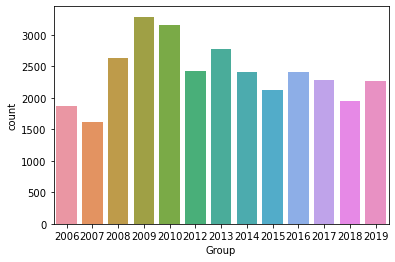

In [37]:
sns.countplot(uni.Group);

In [52]:
def faz_analise(df, tema = 'cyber'):
    print(df.filter(like=tema, axis=0))
    analise = df.filter(like=tema, axis=0).groupby('Group',).sum()
    analise.reset_index(inplace = True)
    analise['assunto'] = tema
    
    return analise

In [39]:
analise = faz_analise(uni)


                  quantidade  porcentagem Group
cyber                   13.0     0.001385  2008
cybersecurity            1.0     0.000107  2008
cyber                   14.0     0.001014  2009
cybersecurity            4.0     0.000290  2009
cyberspace               2.0     0.000145  2009
cyber                   27.0     0.002044  2010
cyberspace               5.0     0.000379  2010
cybersecurity            3.0     0.000227  2010
cyber                   12.0     0.001632  2012
cybersecurity            1.0     0.000136  2012
cyber                   27.0     0.002854  2013
cyberspace               3.0     0.000317  2013
cybercriminals           2.0     0.000211  2013
cybercrime               1.0     0.000106  2013
cyber                   19.0     0.002419  2014
cyberspace               2.0     0.000255  2014
cyber                   42.0     0.006797  2015
cyberspace               1.0     0.000162  2015
cyber                   23.0     0.002959  2016
cyberattacks             3.0     0.00038

In [40]:
analise

,Group,quantidade,porcentagem
0,2008,14.0,0.001491
1,2009,20.0,0.001449
2,2010,35.0,0.002650
3,2012,13.0,0.001768
4,2013,33.0,0.003488
5,2014,21.0,0.002674
6,2015,43.0,0.006959
7,2016,30.0,0.003860
8,2017,52.0,0.007102
9,2018,39.0,0.006763


In [41]:
anos_vazios = {
    'Group': [2006, 2007],
    'quantidade': [0, 0],
    'porcentagem': [0, 0]
}

In [42]:
analise = analise.append( pd.DataFrame(anos_vazios), ignore_index=True)
analise = analise.astype({'Group': 'int32'}).sort_values(by=['Group']).reset_index().drop(columns=['index'])
analise

,Group,quantidade,porcentagem
0,2006,0.0,0.000000
1,2007,0.0,0.000000
2,2008,14.0,0.001491
3,2009,20.0,0.001449
4,2010,35.0,0.002650
5,2012,13.0,0.001768
6,2013,33.0,0.003488
7,2014,21.0,0.002674
8,2015,43.0,0.006959
9,2016,30.0,0.003860


In [40]:
#d2016.filter(like='cyber', axis=0)

,quantidade,porcentagem
cyber,23,0.002959
cyberattacks,3,0.000386
cyberattack,2,0.000257
cybersecurity,1,0.000129
cyberspace,1,0.000129


In [43]:
sns.set_palette("Dark2_r")
sns.set_style("darkgrid")

In [57]:
def plota_analise(df, tipo=['porcentagem', 'quantidade'], graf=['barra', 'linha']):
    plt.figure(figsize=(14,8))
    if graf == 'barra':
        ax = sns.barplot(data=df, x="Group", y=tipo,
                     palette="Blues_d")
    else:
        ax = sns.lineplot(data=df, x="Group", y=tipo)
    plt.title('Evolução de '+tipo+' por ano')
    plt.savefig('evolucao_'+tipo+'_por_ano_barra.png')
    plt.show()

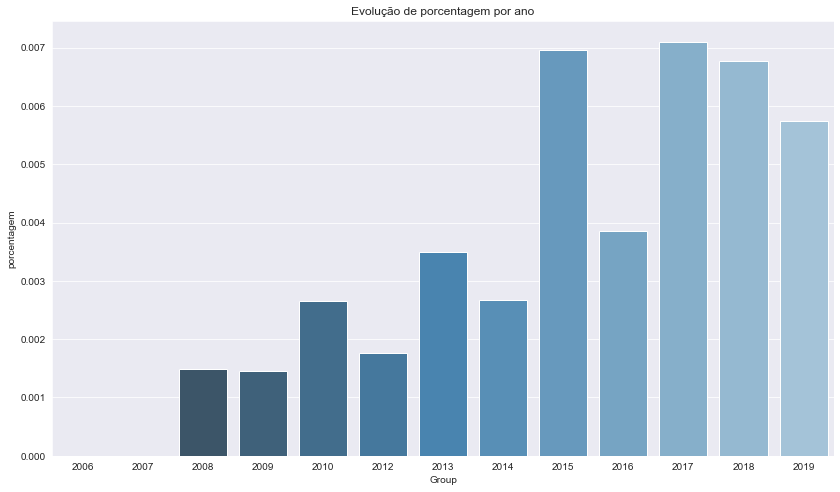

In [58]:
plota_analise(analise,'porcentagem', 'barra')  #

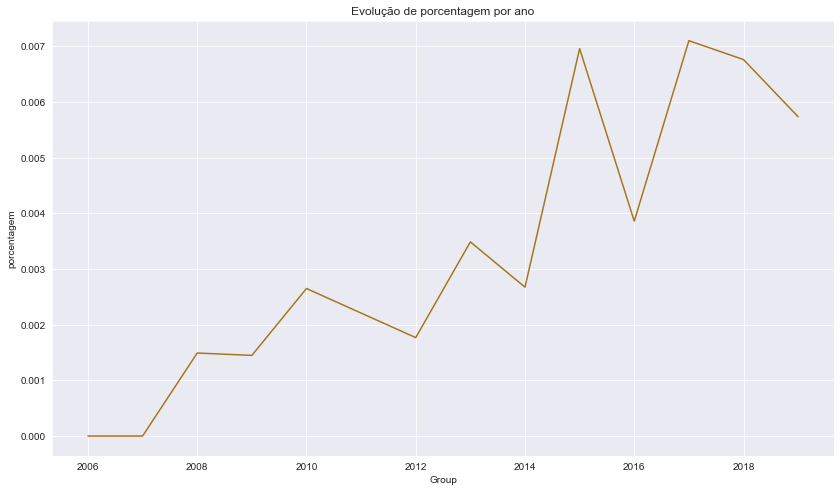

In [48]:
plota_analise(analise,'porcentagem', 'linha')

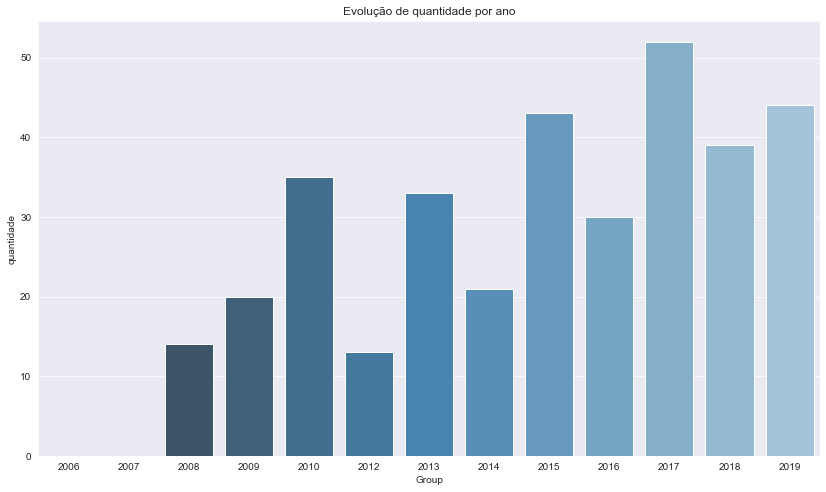

In [49]:
plota_analise(analise,'quantidade', 'barra')

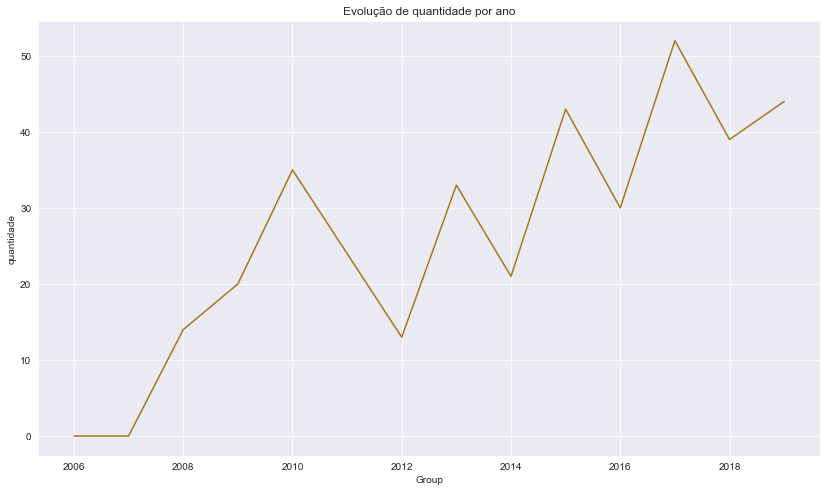

In [50]:
plota_analise(analise,'quantidade', 'linha')

Ta ok. Fazer isso por ano e uma linha do tempo

In [53]:
nuke = faz_analise(uni, 'nuclear')

                  quantidade  porcentagem Group
nuclear                 18.0     0.003625  2006
nuclear                 15.0     0.004003  2007
nuclear                 60.0     0.006390  2008
denuclearization         2.0     0.000213  2008
nuclear                 63.0     0.004564  2009
denuclearization         1.0     0.000072  2009
nuclear                 46.0     0.003483  2010
denuclearization         2.0     0.000151  2010
nuclear                 32.0     0.004352  2012
nuclear                 29.0     0.003065  2013
nuclear                 23.0     0.002928  2014
nuclear                 16.0     0.002589  2015
nuclear                 21.0     0.002702  2016
thermonuclear            1.0     0.000129  2016
nuclear                 24.0     0.003278  2017
nuclear                 16.0     0.002774  2018
nuclear                 29.0     0.003780  2019
denuclearization         8.0     0.001043  2019


In [54]:
nuke

,Group,quantidade,porcentagem
0,2006,18.0,0.003625
1,2007,15.0,0.004003
2,2008,62.0,0.006603
3,2009,64.0,0.004636
4,2010,48.0,0.003634
5,2012,32.0,0.004352
6,2013,29.0,0.003065
7,2014,23.0,0.002928
8,2015,16.0,0.002589
9,2016,22.0,0.002830


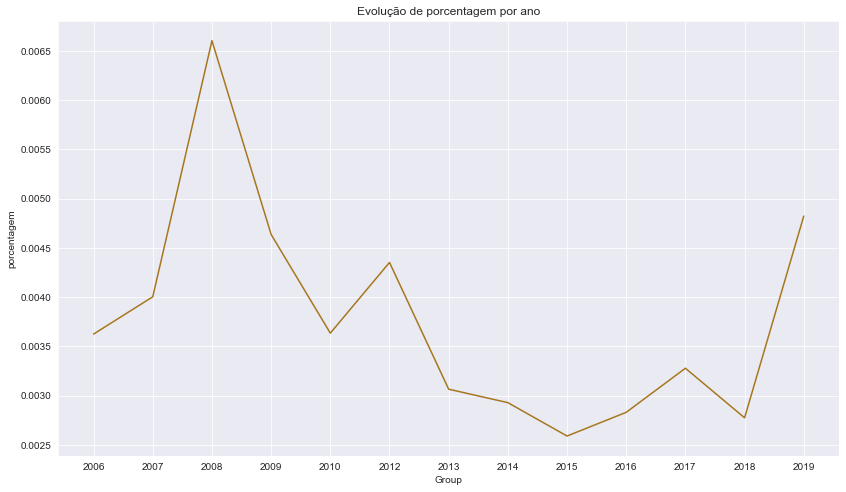

In [83]:
plota_analise(nuke,'porcentagem','linha')

                  quantidade  porcentagem Group
terrorist               20.0     0.004027  2006
terrorism               10.0     0.002014  2006
terror                   6.0     0.001208  2006
counterterrorism         5.0     0.001007  2006
terroristshas            1.0     0.000201  2006
...                      ...          ...   ...
terrorists               1.0     0.000173  2018
counterterror            1.0     0.000173  2018
terrorist               14.0     0.001825  2019
terrorism                5.0     0.000652  2019
counterterrorism         4.0     0.000521  2019

[62 rows x 3 columns]


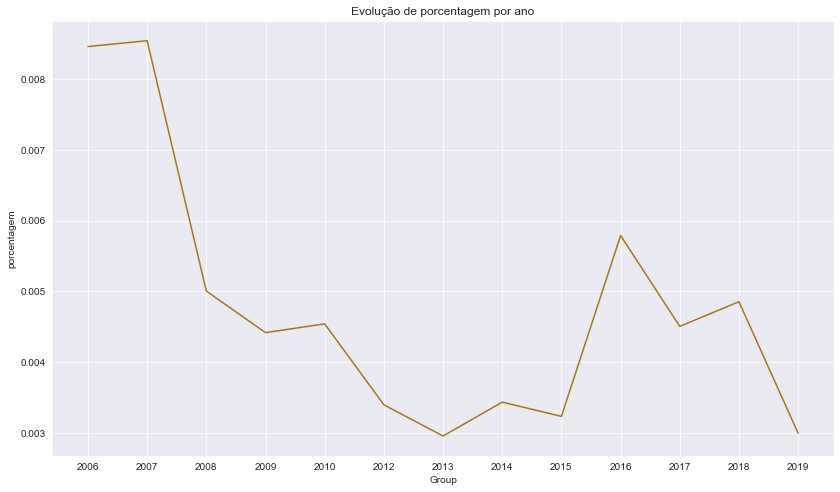

In [60]:
terror = faz_analise(uni, 'terror')
plota_analise(terror,'porcentagem','linha')

# ATÉ AQUI